In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

The purpose of this notebook is to develop an alternative to MC-based uncertainties estimate.
The basic premise relies on perturbin one band at a time by +/-0.15%, build the jacobian (J; where derivative of reflectance at the perturbed band is taken with respect to TOA radiance at each band - columns of $J$ are measurements at each pixel) for each band perturbation relative to the baseline data and propagate using $J^TSJ$, where $S$ is the variance-covariance matrix.

In [3]:
''' Process: 
        * load the baseline L2
        * calculate the S (nxn) matrix using the poly.fit from the SNR workbook.
        * build J for each band like so:
            - loop over each perturbed L2 (here vvv_p is some visible band from the perturbed file, 
          vvv_b is same from the baseline file, and vvv is some visible band:
            - do (Rrs_vvv_p - Rrs_vvv_b) / (Lt_vvp_p - Lt_vvp_b) for reach Rrs band (vvv)
            - repeat for each Rrs retrieval and build J for that particular band
        * do the lin. alg. for each band perturbation like so:
            - np.dot(np.dot(J_vvv.T,S),J_vvv)
            - the result is a (mxm) matrix 
            ''';
            

In [3]:
""" This function builds the final matrix such that data from 
each file can be looped through just once.
Note    -> 1 baseline (bsl) file and n perturbed (prt) files 
        -> for each pixel there will be 1 var-cov matx.
        -> var (uncert **2) for each band is on the diagonal
Some defs:
        -> dRrs(n) = 
* load bsl file 
* in bsl file-> if not created yet create Rrs_unc_nnn nc variables
*  for each pixel p 
                    -> initialize an nxn matrix
                    -> get Rrs(band0-->bandn)bsl
                    -> get Lt(band0 -->bandn)bsl
                    -> from Lt_bsl(b0-bn) get sigma_lt(b0-bn) 
                            using polyfit coeffs (snr workbook)
                    -> from sigma_lt(b0-bn) get var_lt(b0-bn)

                    * for each prt file i 
                        -> get Lt(band i)prt 

                        -> calc Col i of JtS:
                            -> for each band(row) b:

                                (sigLt_i)**2 *dRrs(b)/dLt_i
                         var_Rrs_n = 0
                         var_Rrs_n += ((sigLt_i)**2(dRrs_n/dLt_i)**2   


"""

In [3]:
def GetProdData(prodName,gv,ds=None,datType=None,badVal=-32767.0):
        
        
    if prodName in gv:
        # first flag data
        l2flagsArr = np.array(gv['l2_flags'])
        # build a binary flag mask
        fail = 2**0 + 2**1+ 2**3 + 2**4 + 2**6+ 2**8+ 2**9 + 2**12 + (
            2**15) + 2**20+ 2**24 + 2**25 +2**30

        # apply flag
        cfArr = (l2flagsArr&fail) == 0
        returnData = np.array(gv[prodName])
        returnData[~cfArr] = np.nan
        # flatten array for ease of manip.
        returnData = returnData.flatten()
        
        returnData[~np.isnan(returnData)< 0] = np.nan
        returnData[returnData == badVal] = np.nan
    
    else:
        returnData=-1
        
    return returnData


def GetNCRefs(fileName,mode='r'):
    
    ds = nc.Dataset(fileName,mode=mode)
    gGr = ds.groups['geophysical_data']
    gVr = gGr.variables
    
    return ds,gVr

def ApplyLims(sigs,lims):
    
    sigs[sigs[~np.isnan(sigs)]<lims[0]] = lims[0]
    sigs[sigs[~np.isnan(sigs)]>lims[1]] = lims[1]
    
    return sigs

         
def ApplyPolyFit(cf,lt,deg):
    y = 0
    for i in range(deg):
        y += cf[i] * (lt** (deg - i))
    y += cf[deg]
    return y

c412 = np.array([-8.28726301e-11,3.85425664e-07,-9.10776926e-04
                 ,1.65881862e+00,4.54351582e-01])
c443 = np.array([-1.21871258e-10,5.21579320e-07,-1.14574109e-03
                 ,1.96509056e+00,4.18921861e-01])
c490 = np.array([-2.99068165e-10,1.05225457e-06,-1.90591166e-03
                 ,2.66343986e+00,6.67187489e-01])
c510 = np.array([-5.68939986e-10,1.67950509e-06,-2.56915149e-03
                 ,3.05832773e+00,9.34468454e-01])
c555 = np.array([-1.31635902e-09,3.09617393e-06,-3.73473556e-03
                 ,3.52394751e+00,3.54105899e-01])
c670 = np.array([-8.65458303e-09,1.18857306e-05,-8.37771886e-03
                 ,4.64496430e+00,4.14633422e-02])
c765 = np.array([-4.96827099e-08,4.50239057e-05,-2.10425126e-02
                 ,7.75862055e+00,5.18893137e-02])
c865 = np.array([-1.30487418e-07,9.35407901e-05,-3.40988182e-02
                 ,9.43414239e+00,7.84956550e-01])

sigLim412=[0.0008826466289493833,0.058990630111850566]
sigLim443=[0.00078708204284562292,0.050110810767361902]
sigLim490=[0.00073633772526737848,0.036883976493020949]
sigLim510=[0.00074975219339103519,0.031987200608546547]
sigLim555=[0.00080870577569697015,0.055925717740595647]
sigLim670=[0.0010890690698014294,0.04336828983700642]
sigLim765=[0.00093810092188024833,0.026092951412422679]
sigLim865=[0.0010906675048335769,0.02122474906498301]

color412='#001166'
color443='#004488'
color490='#116688'
color510='#228844'
color555='#667722'
color670='#aa2211'
color765='#770500'
color865='#440000'

In [5]:
def LoadBaseLine(fpath,rrsDict,ltDict):# loading baseline data
    
    dsBsl,geoVarBsl = GetNCRefs(fnpath)
    for band in dataDict.keys():
        prodRrs = 'Rrs_' + band
        prodLt = 'Lt_' + band
        rrsDict[band] = GetProdData(prodRrs,geoVarBsl)
        ltDict[band] = GetProdData(prodLt,geoVarBsl)
        
    return rrsDict,ltDict

def UpdVarFromPertDat(path,ltBand,coef,sigLim,ltBsl):
    deg = 4
    dsp,gvp = GetNCRefs(path)
    
    prodLt = 'Lt_' + str(ltband)
    ltPert = GetProdData(prodLt,gvp)
    ltSigma = 1/ ApplyPolyFit(coef,ltBslDict[ltBand],deg)
    ltSigma  = ApplyLims(ltSigma,sigLim)
    dlt = ltPert - ltBs
    
    

In [8]:
fnDir='./DATA/L2/'
fnbN='S2003182003236'
fnBslSfx='_silent_Det_WorkCopy.L2'
fnpathBsl = fnDir+fnbN+fnBslSfx



bands = ['412','443','490','510','555','670','765','865']

dsBsl,geoVarBsl = GetNCRefs(fnpathBsl)

Rrs_412bsl = GetProdData('Rrs_412',geoVarBsl)
Rrs_443bsl = GetProdData('Rrs_443',geoVarBsl)
Rrs_490bsl = GetProdData('Rrs_490',geoVarBsl)
Rrs_510bsl = GetProdData('Rrs_510',geoVarBsl)
Rrs_555bsl = GetProdData('Rrs_555',geoVarBsl)
Rrs_670bsl = GetProdData('Rrs_670',geoVarBsl)
Rrs_765bsl = GetProdData('Rrs_765',geoVarBsl)
Rrs_865bsl = GetProdData('Rrs_865',geoVarBsl)

In [14]:
Var412 = np.zeros_like(Rrs_412bsl)
Var443 = np.zeros_like(Rrs_443bsl)
Var490 = np.zeros_like(Rrs_490bsl)
Var510 = np.zeros_like(Rrs_510bsl)
Var555 = np.zeros_like(Rrs_555bsl)
Var670 = np.zeros_like(Rrs_670bsl)
Var765 = np.zeros_like(Rrs_765bsl)
Var865 = np.zeros_like(Rrs_865bsl)

In [15]:
# process the first perturbed file (412)
fnpdir = './MC-AnalyticComp/Analytic/'
fnp412sfx = '_w0_p0p0001.L2'
fnpathp412 = fnpdir+fnbN+fnp412sfx
dspert0,geoVar = GetNCRefs(fnpathp412)
Rrs_412pert0 = GetProdData('Rrs_412',geoVar)
Rrs_443pert0 = GetProdData('Rrs_443',geoVar)
Rrs_490pert0 = GetProdData('Rrs_490',geoVar)
Rrs_510pert0 = GetProdData('Rrs_510',geoVar)
Rrs_555pert0 = GetProdData('Rrs_555',geoVar)
Rrs_670pert0 = GetProdData('Rrs_670',geoVar)
Rrs_765pert0 = GetProdData('Rrs_765',geoVar)
Rrs_865pert0 = GetProdData('Rrs_865',geoVar)

Lt_412pert0 = GetProdData('Lt_412',geoVar)
Lt_412bsl = GetProdData('Lt_412',geoVarBsl)

S_412 = 1 / ApplyPolyFit(c412,Lt_412bsl,4)
S_412 = ApplyLims(S_412,sigLim412)

dspert0.close()
del geoVar

dLt412 = Lt_412pert0 - Lt_412bsl
#del Lt_412pert0

sig412_0 = S_412 * (Rrs_412pert0 - Rrs_412bsl) / dLt412
#del Rrs_412pert0

Var412+= (sig412_0) **2
#del sig412_0

sig443_0 = S_412 * (Rrs_443pert0 - Rrs_443bsl)/dLt412
#del Rrs_443pert0

Var443 += (sig443_0) ** 2
#del sig443_0

sig490_0 = S_412 * (Rrs_490pert0 - Rrs_490bsl)/dLt412
#del Rrs_490pert0

Var490 += (sig490_0) ** 2
#del sig490_0,dLt412

sig510_0 = S_412 * (Rrs_510pert0 - Rrs_510bsl) / dLt412
#del Rrs_510pert0

Var510 += sig510_0** 2

sig555_0 = S_412 * (Rrs_555pert0 - Rrs_555bsl) / dLt412
# del Rrs_555pert0

Var555 += sig555_0 ** 2

sig670_0 = S_412 * (Rrs_670pert0 - Rrs_670bsl) / dLt412
# del Rrs_670pert0

Var670 += sig670_0 ** 2

sig765_0 = S_412 * (Rrs_765pert0 - Rrs_765bsl) / dLt412
# del Rrs_765pert0

Var765 += sig765_0 ** 2

sig865_0 = S_412 * (Rrs_865pert0 - Rrs_865bsl) / dLt412
# del Rrs_865pert0

Var865 += sig865_0 ** 2

In [31]:
# process the second perturbed file (443)
fnp443sfx = '_w1_p0p0001.L2'
fnpathp443 = fnpdir+fnbN+fnp443sfx
dspert1,geoVar = GetNCRefs(fnpathp443)
Rrs_412pert1 = GetProdData('Rrs_412',geoVar)
Rrs_443pert1 = GetProdData('Rrs_443',geoVar)
Rrs_490pert1 = GetProdData('Rrs_490',geoVar)
Rrs_510pert1 = GetProdData('Rrs_510',geoVar)
Rrs_555pert1 = GetProdData('Rrs_555',geoVar)
Rrs_670pert1 = GetProdData('Rrs_670',geoVar)
Rrs_765pert1 = GetProdData('Rrs_765',geoVar)
Rrs_865pert1 = GetProdData('Rrs_865',geoVar)

Lt_443pert1 = GetProdData('Lt_443',geoVar)
Lt_443bsl = GetProdData('Lt_443',geoVarBsl)

S_443 = 1 / ApplyPolyFit(c443,Lt_443bsl,4)
S_443 = ApplyLims(S_443,sigLim443)

dspert1.close()
del geoVar

dLt443 = Lt_443pert1 - Lt_443bsl
#del Lt_443pert1

sig412_1 = S_443 * (Rrs_412pert1 - Rrs_412bsl) / dLt443
#del Rrs_412pert1

Var412+= (sig412_1) ** 2
#del sig412_1

sig443_1 = S_443 * (Rrs_443pert1 - Rrs_443bsl) / dLt443
#del Rrs_443pert1

Var443 += (sig443_1) ** 2
#del sig443_1

sig490_1 = S_443 * (Rrs_490pert1 - Rrs_490bsl) / dLt443
#del Rrs_490pert1

Var490 += (sig490_1) ** 2
#del sig490_1,dLt443

sig510_1 = S_443 * (Rrs_510pert1 - Rrs_510bsl) / dLt443
#del Rrs_510pert0

Var510 += sig510_1** 2

sig555_1 = S_443 * (Rrs_555pert1 - Rrs_555bsl) / dLt443
# del Rrs_555pert0

Var555 += sig555_1 ** 2

sig670_1 = S_443 * (Rrs_670pert1 - Rrs_670bsl) / dLt443
# del Rrs_670pert0

Var670 += sig670_1 ** 2

sig765_1 = S_443 * (Rrs_765pert1 - Rrs_765bsl) / dLt443
# del Rrs_765pert0

Var765 += sig765_1 ** 2

sig865_1 = S_443 * (Rrs_865pert1 - Rrs_865bsl) / dLt443
# del Rrs_865pert0

Var865 += sig865_1 ** 2

In [13]:
del Rrs_412pert1,Rrs_443pert1,Rrs_490pert1,Rrs_510pert1,Rrs_555pert1,Rrs_670pert1,Rrs_765pert1,Rrs_865pert1\
        ,sig412_1,sig443_1,sig490_1,sig510_1,sig555_1,sig670_1,sig765_1,sig865_1
# process third perturbed file (490)
fnp490sfx = '_w2_p0p0001.L2'
fnpathp490 = fnpdir+fnbn+fnp490sfx
dspert2,geoVar = GetNCRefs(fnpathp490)

Rrs_412pert2 = GetOrCreateUnc('Rrs_412',geoVar)
Rrs_443pert2 = GetOrCreateUnc('Rrs_443',geoVar)
Rrs_490pert2 = GetOrCreateUnc('Rrs_490',geoVar)
Rrs_510pert2 = GetOrCreateUnc('Rrs_510',geoVar)
Rrs_555pert2 = GetOrCreateUnc('Rrs_555',geoVar)
Rrs_670pert2 = GetOrCreateUnc('Rrs_670',geoVar)
Rrs_765pert2 = GetOrCreateUnc('Rrs_765',geoVar)
Rrs_865pert2 = GetOrCreateUnc('Rrs_865',geoVar)

Lt_490pert2 = GetOrCreateUnc('Lt_490',geoVar)
Lt_490bsl = GetOrCreateUnc('Lt_490',geoVarBsl)

S_490 = 1 / ApplyPolyFit(c490,Lt_490bsl,4)
S_490 = ApplyLims(S_490,sigLim490)

dspert2.close()
del geoVar

dLt490 = Lt_490pert2 - Lt_490bsl
del Lt_490pert2
sig412_2 = S_490 * (Rrs_412pert2 - Rrs_412bsl) / dLt490
del Rrs_412pert2

Var412 += (sig412_2) **2
del sig412_2

sig443_2 = S_490 * (Rrs_443pert2 - Rrs_443bsl) / dLt490
del Rrs_443pert2

Var443 += (sig443_2) ** 2
del sig443_2

sig490_2 = S_490 * (Rrs_490pert2 - Rrs_490bsl) / dLt490
del Rrs_490pert2

Var490 += (sig490_2) ** 2
del sig490_2
sig510_2 = S_490 * (Rrs_510pert2 - Rrs_510bsl) / dLt490
#del Rrs_510pert0

Var510 += sig510_2 ** 2

sig555_2 = S_490 * (Rrs_555pert2 - Rrs_555bsl) / dLt490
# del Rrs_555pert0

Var555 += sig555_2 ** 2

sig670_2 = S_490 * (Rrs_670pert2 - Rrs_670bsl) / dLt490
# del Rrs_670pert0

Var670 += sig670_2 ** 2

sig765_2 = S_490 * (Rrs_765pert2 - Rrs_765bsl) / dLt490
# del Rrs_765pert0

Var765 += sig765_2 ** 2

sig865_2 = S_490 * (Rrs_865pert2 - Rrs_865bsl) / dLt490
# del Rrs_865pert0

Var865 += sig865_2 ** 2

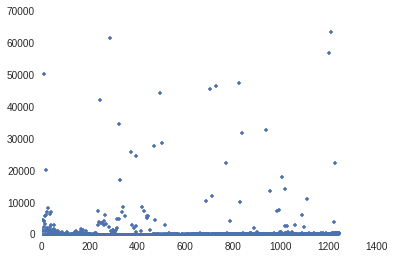

In [26]:
plt.plot(sig865,marker='.',ls='')

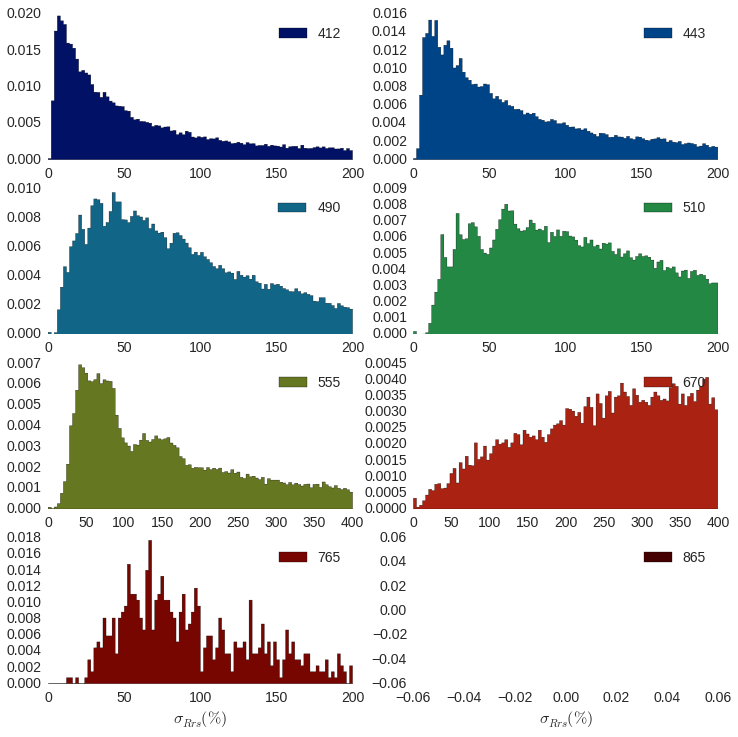

In [28]:
Sig412 = np.sqrt(Var412)
Sig443 = np.sqrt(Var443)
Sig490 = np.sqrt(Var490)
Sig510 = np.sqrt(Var510)
Sig555 = np.sqrt(Var555)
Sig670 = np.sqrt(Var670)
Sig765 = np.sqrt(Var765)
Sig865 = np.sqrt(Var865)

a= np.nonzero(Rrs_412bsl)
Sig412perc = 100 * Sig412[a]/Rrs_412bsl[a]
del a
a = np.nonzero(Rrs_443bsl)
Sig443perc = 100 * Sig443[a]/Rrs_443bsl[a]
del a
a = np.nonzero(Rrs_490bsl)
Sig490perc = 100 * Sig490[a]/Rrs_490bsl[a]
del a
a = np.nonzero(Rrs_510bsl)
Sig510perc = 100 * Sig510[a]/Rrs_510bsl[a]
del a
a = np.nonzero(Rrs_555bsl)
Sig555perc = 100 * Sig555[a]/Rrs_555bsl[a]
del a
a = np.nonzero(Rrs_670bsl)
Sig670perc = 100 * Sig670[a]/Rrs_670bsl[a]
del a
a =np.nonzero(Rrs_765bsl)
Sig765perc = 100 * Sig765[a]/Rrs_765bsl[a]
del a
a = np.nonzero(Rrs_865bsl)
Sig865perc = 100 * Sig865[a]/Rrs_865bsl[a]
del a

sig412 = Sig412perc[~np.isnan(Sig412perc)]
sig443 = Sig443perc[~np.isnan(Sig443perc)]
sig490 = Sig490perc[~np.isnan(Sig490perc)]
sig510 = Sig510perc[~np.isnan(Sig510perc)]
sig555 = Sig555perc[~np.isnan(Sig555perc)]
sig670 = Sig670perc[~np.isnan(Sig670perc)]
sig765 = Sig765perc[~np.isnan(Sig765perc)]
sig865 = Sig865perc[~np.isnan(Sig865perc)]

plt.figure(figsize=(12,12))
plt.subplot(421)
plt.hist(sig412[sig412>0],bins=100,range=[0,200],normed=True,histtype = 'stepfilled',color='#001166',
         label='412');
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.subplot(422)
plt.hist(sig443[sig443>0],bins=100,range=[0,200],normed=True,histtype='stepfilled',color='#004488',label='443');
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.subplot(423)
plt.hist(sig490[sig490>0],bins=100,range=[0,200],normed=True,histtype='stepfilled',color='#116688',label='490');
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.subplot(424)
plt.hist(sig510[sig510>0],bins=100,range=[0,200],normed=True,histtype='stepfilled',color='#228844',label='510')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.subplot(425)
plt.hist(sig555[sig555>0],bins=100,range=[0,400],normed=True,histtype='stepfilled',color='#667722',label='555')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.subplot(426)
plt.hist(sig670[sig670>0],bins=100,range=[0,400],normed=True,histtype='stepfilled',color='#aa2211',label='670')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.subplot(427)
plt.hist(sig765[sig765>0],bins=100,range=[0,200],normed=True,histtype='stepfilled',color='#770500',label='765')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.xlabel(r'$\sigma_{Rrs} (\%)$',fontsize=16,fontweight='bold')
plt.subplot(428)
plt.hist(sig865[sig865>0],bins=100,range=[0,20],normed=True,color='#440000',label = '865')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.xlabel(r'$\sigma_{Rrs} (\%)$',fontsize=16,fontweight='bold')
#plt.show()

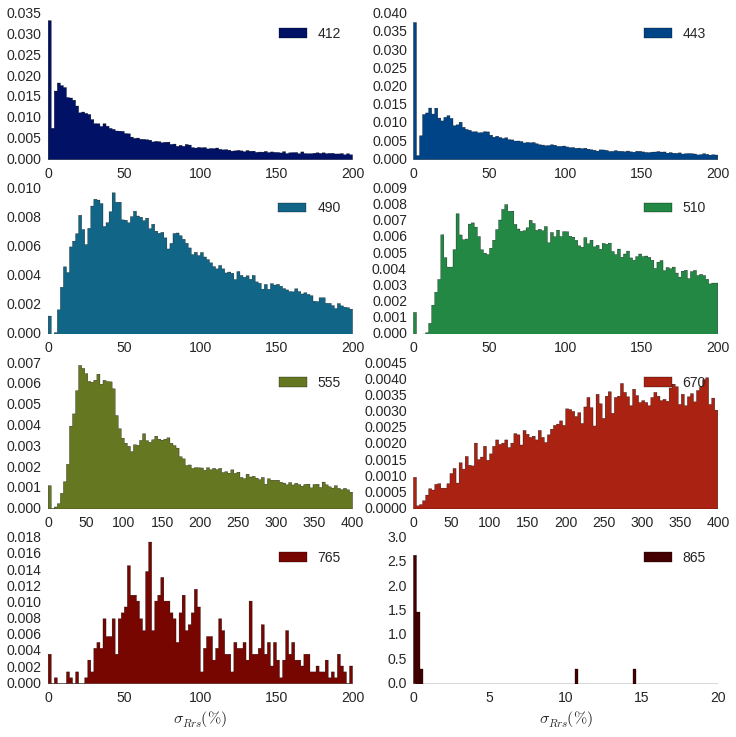

In [32]:
Sig412 = np.sqrt(Var412)
Sig443 = np.sqrt(Var443)
Sig490 = np.sqrt(Var490)
Sig510 = np.sqrt(Var510)
Sig555 = np.sqrt(Var555)
Sig670 = np.sqrt(Var670)
Sig765 = np.sqrt(Var765)
Sig865 = np.sqrt(Var865)

a= np.nonzero(Rrs_412bsl)
Sig412perc = 100 * Sig412[a]/Rrs_412bsl[a]
del a
a = np.nonzero(Rrs_443bsl)
Sig443perc = 100 * Sig443[a]/Rrs_443bsl[a]
del a
a = np.nonzero(Rrs_490bsl)
Sig490perc = 100 * Sig490[a]/Rrs_490bsl[a]
del a
a = np.nonzero(Rrs_510bsl)
Sig510perc = 100 * Sig510[a]/Rrs_510bsl[a]
del a
a = np.nonzero(Rrs_555bsl)
Sig555perc = 100 * Sig555[a]/Rrs_555bsl[a]
del a
a = np.nonzero(Rrs_670bsl)
Sig670perc = 100 * Sig670[a]/Rrs_670bsl[a]
del a
a =np.nonzero(Rrs_765bsl)
Sig765perc = 100 * Sig765[a]/Rrs_765bsl[a]
del a
a = np.nonzero(Rrs_865bsl)
Sig865perc = 100 * Sig865[a]/Rrs_865bsl[a]
del a

sig412 = Sig412perc[~np.isnan(Sig412perc)]
sig443 = Sig443perc[~np.isnan(Sig443perc)]
sig490 = Sig490perc[~np.isnan(Sig490perc)]
sig510 = Sig510perc[~np.isnan(Sig510perc)]
sig555 = Sig555perc[~np.isnan(Sig555perc)]
sig670 = Sig670perc[~np.isnan(Sig670perc)]
sig765 = Sig765perc[~np.isnan(Sig765perc)]
sig865 = Sig865perc[~np.isnan(Sig865perc)]

plt.figure(figsize=(12,12))
plt.subplot(421)
plt.hist(sig412[sig412>0],bins=100,range=[0,200],normed=True,histtype = 'stepfilled',color='#001166',
         label='412');
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.subplot(422)
plt.hist(sig443[sig443>0],bins=100,range=[0,200],normed=True,histtype='stepfilled',color='#004488',label='443');
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.subplot(423)
plt.hist(sig490[sig490>0],bins=100,range=[0,200],normed=True,histtype='stepfilled',color='#116688',label='490');
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.subplot(424)
plt.hist(sig510[sig510>0],bins=100,range=[0,200],normed=True,histtype='stepfilled',color='#228844',label='510')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.subplot(425)
plt.hist(sig555[sig555>0],bins=100,range=[0,400],normed=True,histtype='stepfilled',color='#667722',label='555')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.subplot(426)
plt.hist(sig670[sig670>0],bins=100,range=[0,400],normed=True,histtype='stepfilled',color='#aa2211',label='670')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.subplot(427)
plt.hist(sig765[sig765>0],bins=100,range=[0,200],normed=True,histtype='stepfilled',color='#770500',label='765')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.xlabel(r'$\sigma_{Rrs} (\%)$',fontsize=16,fontweight='bold')
plt.subplot(428)
plt.hist(sig865[sig865>0],bins=100,range=[0,20],normed=True,color='#440000',label = '865')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.xlabel(r'$\sigma_{Rrs} (\%)$',fontsize=16,fontweight='bold')
#plt.show()

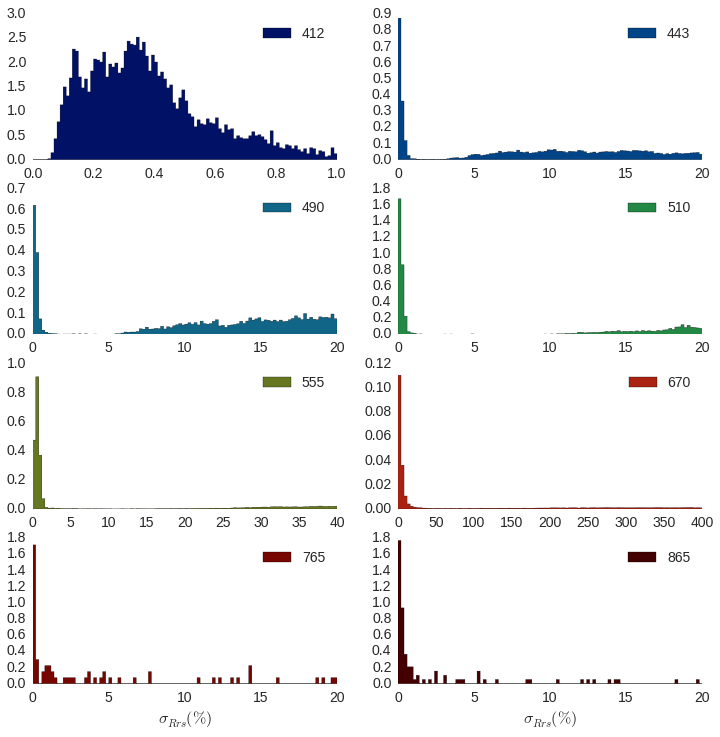

In [19]:
Sig412 = np.sqrt(Var412)
#del Var412

Sig443 = np.sqrt(Var443)
#del Var443

Sig490 = np.sqrt(Var490)
#del Var490

Sig510 = np.sqrt(Var510)
Sig555 = np.sqrt(Var555)
Sig670 = np.sqrt(Var670)
Sig765 = np.sqrt(Var765)
Sig865 = np.sqrt(Var865)

a= np.nonzero(Rrs_412bsl)
Sig412perc = 100 * Sig412[a]/Rrs_412bsl[a]
del a
a = np.nonzero(Rrs_443bsl)
Sig443perc = 100 * Sig443[a]/Rrs_443bsl[a]
del a
a = np.nonzero(Rrs_490bsl)
Sig490perc = 100 * Sig490[a]/Rrs_490bsl[a]
del a
a = np.nonzero(Rrs_510bsl)
Sig510perc = 100 * Sig510[a]/Rrs_510bsl[a]
del a
a = np.nonzero(Rrs_555bsl)
Sig555perc = 100 * Sig555[a]/Rrs_555bsl[a]
del a
a = np.nonzero(Rrs_670bsl)
Sig670perc = 100 * Sig670[a]/Rrs_670bsl[a]
del a

a =np.nonzero(Rrs_765bsl)
Sig765perc = 100 * Sig765[a]/Rrs_765bsl[a]
del a
a = np.nonzero(Rrs_865bsl)
Sig865perc = 100 * Sig865[a]/Rrs_865bsl[a]
del a
sig412 = Sig412perc[~np.isnan(Sig412perc)]
sig443 = Sig443perc[~np.isnan(Sig443perc)]
sig490 = Sig490perc[~np.isnan(Sig490perc)]
sig510 = Sig510perc[~np.isnan(Sig510perc)]
sig555 = Sig555perc[~np.isnan(Sig555perc)]
sig670 = Sig670perc[~np.isnan(Sig670perc)]
sig765 = Sig765perc[~np.isnan(Sig765perc)]
sig865 = Sig865perc[~np.isnan(Sig865perc)]

plt.figure(figsize=(12,12))
plt.hist(Sig412[~np.isnan(Sig412)],bins=100)
plt.subplot(421)
plt.hist(sig412[sig412>0],bins=100,range=[0,1],normed=True,histtype = 'stepfilled',color='#001166',
         label='412');
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.subplot(422)
plt.hist(sig443[sig443>0],bins=100,range=[0,20],normed=True,histtype='stepfilled',color='#004488',label='443');
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.subplot(423)
plt.hist(sig490[sig490>0],bins=100,range=[0,20],normed=True,histtype='stepfilled',color='#116688',label='490');
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.subplot(424)
plt.hist(sig510[sig510>0],bins=100,range=[0,20],normed=True,histtype='stepfilled',color='#228844',label='510')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.subplot(425)
plt.hist(sig555[sig555>0],bins=100,range=[0,40],normed=True,histtype='stepfilled',color='#667722',label='555')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.subplot(426)
plt.hist(sig670[sig670>0],bins=100,range=[0,400],normed=True,histtype='stepfilled',color='#aa2211',label='670')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.subplot(427)
plt.hist(sig765[sig765>0],bins=100,range=[0,20],normed=True,histtype='stepfilled',color='#770500',label='765')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.xlabel(r'$\sigma_{Rrs} (\%)$',fontsize=16,fontweight='bold')
plt.subplot(428)
plt.hist(sig865[sig865>0],bins=100,range=[0,20],normed=True,histtype='stepfilled',color='#440000',label = '865')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.xlabel(r'$\sigma_{Rrs} (\%)$',fontsize=16,fontweight='bold')
#plt.show()

In [14]:
### process the 4th perturbed file (510)
fnpdir = './MC-AnalyticComp/Analytic/'
fnp510sfx = '_w3_p0p0001.L2'
fnpathp510 = fnpdir+fnbn+fnp510sfx
dspert3,geoVar = GetNCRefs(fnpathp510)

Rrs_412pert3 = GetOrCreateUnc('Rrs_412',geoVar)
Rrs_443pert3 = GetOrCreateUnc('Rrs_443',geoVar)
Rrs_490pert3 = GetOrCreateUnc('Rrs_490',geoVar)
Rrs_510pert3 = GetOrCreateUnc('Rrs_510',geoVar)
Rrs_555pert3 = GetOrCreateUnc('Rrs_555',geoVar)
Rrs_670pert3 = GetOrCreateUnc('Rrs_670',geoVar)
Rrs_765pert3 = GetOrCreateUnc('Rrs_765',geoVar)
Rrs_865pert3 = GetOrCreateUnc('Rrs_865',geoVar)

Lt_510pert3 = GetOrCreateUnc('Lt_510',geoVar)
Lt_510bsl = GetOrCreateUnc('Lt_510',geoVarBsl)

S_510 = 1 / ApplyPolyFit(c510,Lt_510bsl,4)
S_510 = ApplyLims(S_510,sigLim510)

dspert3.close()
del geoVar,dspert3

dLt510 = Lt_510pert3 - Lt_510bsl
del Lt_510pert3

sig412_3= S_510 * (Rrs_412pert3 - Rrs_412bsl) / dLt510
del Rrs_412pert3

Var412+= (sig412_3) **2
#del sig412_0

sig443_3 = S_510 * (Rrs_443pert3 - Rrs_443bsl) / dLt510
#del Rrs_443pert0

Var443 += (sig443_3) ** 2
#del sig443_0

sig490_3 = S_510 * (Rrs_490pert3 - Rrs_490bsl) / dLt510
#del Rrs_490pert0

Var490 += (sig490_3) ** 2
#del sig490_0,dLt412

sig510_3 = S_510 * (Rrs_510pert3 - Rrs_510bsl) / dLt510
#del Rrs_510pert0

Var510 += sig510_3** 2

sig555_3 = S_510 * (Rrs_555pert3 - Rrs_555bsl) / dLt510
# del Rrs_555pert0

Var555 += sig555_3 ** 2

sig670_3 = S_510 * (Rrs_670pert3 - Rrs_670bsl) / dLt510
# del Rrs_670pert0

Var670 += sig670_3 ** 2

sig765_3 = S_510 * (Rrs_765pert3 - Rrs_765bsl) / dLt510
# del Rrs_765pert0

Var765 += sig765_3 ** 2

sig865_3 = S_510 * (Rrs_865pert3 - Rrs_865bsl) / dLt510
# del Rrs_865pert0

Var865 += sig865_3 ** 2

In [15]:
# process the 5th perturbed file (555)
fnpdir = './MC-AnalyticComp/Analytic/'
fnp555sfx = '_w4_p0p0001.L2'
fnpathp555 = fnpdir+fnbn+fnp555sfx
dspert4,geoVar = GetNCRefs(fnpathp555)

Rrs_412pert4 = GetOrCreateUnc('Rrs_412',geoVar)
Rrs_443pert4 = GetOrCreateUnc('Rrs_443',geoVar)
Rrs_490pert4 = GetOrCreateUnc('Rrs_490',geoVar)
Rrs_510pert4 = GetOrCreateUnc('Rrs_510',geoVar)
Rrs_555pert4 = GetOrCreateUnc('Rrs_555',geoVar)
Rrs_670pert4 = GetOrCreateUnc('Rrs_670',geoVar)
Rrs_765pert4 = GetOrCreateUnc('Rrs_765',geoVar)
Rrs_865pert4 = GetOrCreateUnc('Rrs_865',geoVar)

Lt_555pert4 = GetOrCreateUnc('Lt_555',geoVar)
Lt_555bsl = GetOrCreateUnc('Lt_555',geoVarBsl)

S_555 = 1 / ApplyPolyFit(c555,Lt_555bsl,4)
S_555 = ApplyLims(S_555,sigLim555)

dspert4.close()
del geoVar,dspert4

dLt555 = Lt_555pert4 - Lt_555bsl
del Lt_555pert4

sig412_4= S_555 * (Rrs_412pert4 - Rrs_412bsl) / dLt555
del Rrs_412pert4

Var412+= (sig412_4) **2
#del sig412_0

sig443_4 = S_555 * (Rrs_443pert4 - Rrs_443bsl) / dLt555
#del Rrs_443pert0

Var443 += (sig443_4) ** 2
#del sig443_0

sig490_4 = S_555 * (Rrs_490pert4 - Rrs_490bsl) / dLt555
#del Rrs_490pert0

Var490 += (sig490_4) ** 2
#del sig490_0,dLt412

sig510_4 = S_555 * (Rrs_510pert4 - Rrs_510bsl) / dLt555
#del Rrs_510pert0

Var510 += sig510_4** 2

sig555_4 = S_555 * (Rrs_555pert4 - Rrs_555bsl) / dLt555
# del Rrs_555pert0

Var555 += sig555_4 ** 2

sig670_4 = S_555 * (Rrs_670pert4 - Rrs_670bsl) / dLt555
# del Rrs_670pert0

Var670 += sig670_4 ** 2

sig765_4 = S_555 * (Rrs_765pert4 - Rrs_765bsl) / dLt555
# del Rrs_765pert0

Var765 += sig765_4 ** 2

sig865_4 = S_555 * (Rrs_865pert4 - Rrs_865bsl) / dLt555
# del Rrs_865pert0

Var865 += sig865_4 ** 2

In [16]:
# process the 6th perturbed file (670)
fnpdir = './MC-AnalyticComp/Analytic/'
fnp670sfx = '_w5_p0p0001.L2'
fnpathp670 = fnpdir+fnbn+fnp670sfx
dspert5,geoVar = GetNCRefs(fnpathp670)

Rrs_412pert5 = GetOrCreateUnc('Rrs_412',geoVar)
Rrs_443pert5 = GetOrCreateUnc('Rrs_443',geoVar)
Rrs_490pert5 = GetOrCreateUnc('Rrs_490',geoVar)
Rrs_510pert5 = GetOrCreateUnc('Rrs_510',geoVar)
Rrs_555pert5 = GetOrCreateUnc('Rrs_555',geoVar)
Rrs_670pert5 = GetOrCreateUnc('Rrs_670',geoVar)
Rrs_765pert5 = GetOrCreateUnc('Rrs_765',geoVar)
Rrs_865pert5 = GetOrCreateUnc('Rrs_865',geoVar)

Lt_670pert5 = GetOrCreateUnc('Lt_670',geoVar)
Lt_670bsl = GetOrCreateUnc('Lt_670',geoVarBsl)

S_670 = 1 / ApplyPolyFit(c670,Lt_670bsl,4)
S_670 = ApplyLims(S_670,sigLim670)

dspert5.close()

del geoVar,dspert5

dLt670 = Lt_670pert5 - Lt_670bsl
del Lt_670pert5

sig412_5 = S_670 * (Rrs_412pert5 - Rrs_412bsl) / dLt670
del Rrs_412pert5

Var412+= (sig412_5) **2
#del sig412_0

sig443_5 = S_670 * (Rrs_443pert5 - Rrs_443bsl) / dLt670
#del Rrs_443pert0

Var443 += (sig443_5) ** 2
#del sig443_0

sig490_5 = S_670 *(Rrs_490pert5 - Rrs_490bsl) / dLt670
#del Rrs_490pert0

Var490 += (sig490_5) ** 2
#del sig490_0,dLt412

sig510_5 = S_670 * (Rrs_510pert5 - Rrs_510bsl) / dLt670
#del Rrs_510pert0

Var510 += sig510_5** 2

sig555_5 = S_670 * (Rrs_555pert5 - Rrs_555bsl) / dLt670
# del Rrs_555pert0

Var555 += sig555_5 ** 2

sig670_5 = S_670 * (Rrs_670pert5 - Rrs_670bsl) / dLt670
# del Rrs_670pert0

Var670 += sig670_5 ** 2

sig765_5 = S_670 * (Rrs_765pert5 - Rrs_765bsl) / dLt670
# del Rrs_765pert0

Var765 += sig765_5 ** 2

sig865_5 = S_670 * (Rrs_865pert5 - Rrs_865bsl) / dLt670
# del Rrs_865pert0

Var865 += sig865_5 ** 2

In [17]:
# process the 7th perturbed file (765)
fnpdir = './MC-AnalyticComp/Analytic/'
fnp765sfx = '_w6_p0p0001.L2'
fnpathp765 = fnpdir+fnbn+fnp765sfx
dspert6,geoVar = GetNCRefs(fnpathp765)

Rrs_412pert6 = GetOrCreateUnc('Rrs_412',geoVar)
Rrs_443pert6 = GetOrCreateUnc('Rrs_443',geoVar)
Rrs_490pert6 = GetOrCreateUnc('Rrs_490',geoVar)
Rrs_510pert6 = GetOrCreateUnc('Rrs_510',geoVar)
Rrs_555pert6 = GetOrCreateUnc('Rrs_555',geoVar)
Rrs_670pert6 = GetOrCreateUnc('Rrs_670',geoVar)
Rrs_765pert6 = GetOrCreateUnc('Rrs_765',geoVar)
Rrs_865pert6 = GetOrCreateUnc('Rrs_865',geoVar)

Lt_765pert6 = GetOrCreateUnc('Lt_765',geoVar)
Lt_765bsl = GetOrCreateUnc('Lt_765',geoVarBsl)

S_765 = 1 / ApplyPolyFit(c765,Lt_765bsl,4)
S_765 = ApplyLims(S_765,sigLim765)

dspert6.close()
del geoVar,dspert6

dLt765 = Lt_765pert6 - Lt_765bsl
del Lt_765pert6

sig412_6 = S_765 * (Rrs_412pert6 - Rrs_412bsl) / dLt765
del Rrs_412pert6

Var412+= (sig412_6) **2
#del sig412_6

sig443_6 = S_765 * (Rrs_443pert6 - Rrs_443bsl) / dLt765
#del Rrs_443pert0

Var443 += (sig443_6) ** 2
#del sig443_0

sig490_6 = S_765 * (Rrs_490pert6 - Rrs_490bsl) / dLt765
#del Rrs_490pert0

Var490 += (sig490_6) ** 2
#del sig490_0,dLt412

sig510_6= S_765 * (Rrs_510pert6 - Rrs_510bsl) / dLt765
#del Rrs_510pert0

Var510 += sig510_6 ** 2

sig555_6 = S_765 * (Rrs_555pert6 - Rrs_555bsl) / dLt765
# del Rrs_555pert0

Var555 += sig555_6 ** 2

sig670_6 = S_765 * (Rrs_670pert6 - Rrs_670bsl) / dLt765
# del Rrs_670pert0

Var670 += sig670_6 ** 2

sig765_6 = S_765 * (Rrs_765pert6 - Rrs_765bsl) / dLt765
# del Rrs_765pert0

Var765 += sig765_6 ** 2

sig865_6 = S_765 * (Rrs_865pert6 - Rrs_865bsl) / dLt765
# del Rrs_865pert0

Var865 += sig865_6 ** 2

In [18]:
# process the 8th perturbed file (865)
fnpdir = './MC-AnalyticComp/Analytic/'
fnp865sfx = '_w7_p0p0001.L2'
fnpathp865 = fnpdir+fnbn+fnp865sfx
dspert7,geoVar = GetNCRefs(fnpathp865)

Rrs_412pert7 = GetOrCreateUnc('Rrs_412',geoVar)
Rrs_443pert7 = GetOrCreateUnc('Rrs_443',geoVar)
Rrs_490pert7 = GetOrCreateUnc('Rrs_490',geoVar)
Rrs_510pert7 = GetOrCreateUnc('Rrs_510',geoVar)
Rrs_555pert7 = GetOrCreateUnc('Rrs_555',geoVar)
Rrs_670pert7 = GetOrCreateUnc('Rrs_670',geoVar)
Rrs_765pert7 = GetOrCreateUnc('Rrs_765',geoVar)
Rrs_865pert7 = GetOrCreateUnc('Rrs_865',geoVar)

Lt_865pert7 = GetOrCreateUnc('Lt_865',geoVar)
Lt_865bsl = GetOrCreateUnc('Lt_865',geoVarBsl)

S_865 = 1 / ApplyPolyFit(c865,Lt_865bsl,4)
S_865 = ApplyLims(S_865,sigLim865)

dspert7.close()
del geoVar,dspert7

dLt865 = Lt_865pert7 - Lt_865bsl
del Lt_865pert7

sig412_7 = S_865 * (Rrs_412pert7 - Rrs_412bsl) / dLt865
del Rrs_412pert7

Var412+= (sig412_7) **2
#del sig412_0

sig443_7 = S_865 * (Rrs_443pert7 - Rrs_443bsl) / dLt865
#del Rrs_443pert0

Var443 += (sig443_7) ** 2
#del sig443_0

sig490_7 = S_865 * (Rrs_490pert7 - Rrs_490bsl) / dLt865
#del Rrs_490pert0

Var490 += (sig490_7) ** 2
#del sig490_0,dLt412

sig510_7 = S_510 * (Rrs_510pert7 - Rrs_510bsl) / dLt865
#del Rrs_510pert0

Var510 += sig510_7 ** 2

sig555_7 = S_865 * (Rrs_555pert7 - Rrs_555bsl) / dLt865
# del Rrs_555pert0

Var555 += sig555_7 ** 2

sig670_7 = S_865 * (Rrs_670pert7 - Rrs_670bsl) / dLt865
# del Rrs_670pert0

Var670 += sig670_7 ** 2

sig765_7 = S_865 * (Rrs_765pert7 - Rrs_765bsl) / dLt865
# del Rrs_765pert0

Var765 += sig765_7 ** 2

sig865_7 = S_865 * (Rrs_865pert7 - Rrs_865bsl) / dLt865
# del Rrs_865pert0

Var865 += sig865_7 ** 2

In [20]:
dsBsl.close()
fnbndir='./DATA/L2/'
fnbn='S2003182003236'
fnsilsfx='_silent_MC400.L2'
fnpath = fnbndir+fnbn+fnsilsfx
dsBsl,geoVarBsl = GetNCRefs(fnpath)
Rrs_412unc = GetOrCreateUnc('Rrs_unc_412',geoVarBsl)
Rrs_443unc = GetOrCreateUnc('Rrs_unc_443',geoVarBsl)
Rrs_490unc = GetOrCreateUnc('Rrs_unc_490',geoVarBsl)
Rrs_510unc = GetOrCreateUnc('Rrs_unc_510',geoVarBsl)
Rrs_555unc = GetOrCreateUnc('Rrs_unc_555',geoVarBsl)
Rrs_670unc = GetOrCreateUnc('Rrs_unc_670',geoVarBsl)
Rrs_765unc = GetOrCreateUnc('Rrs_unc_765',geoVarBsl)
Rrs_865unc = GetOrCreateUnc('Rrs_unc_865',geoVarBsl)

In [21]:
def SigmaScatter(detData,mcData,xlims=None,ylims=None,band=None,color=None):
    """
        xlims,ylims: tuple
        band: string
    """
    
    plt.scatter(detData,mcData,label=band,facecolors=color,alpha=0.8)
    
    if not xlims == None:
        plt.xlim(xlims)
    
    if not ylims == None:
        plt.ylim(ylims)
    
    if not band == None:
        plt.legend()
        
    plt.tick_params(labelsize=16)
    plt.title(r'$\sigma_{Rrs} (sr^{-1})$',fontsize=18)
    plt.xlabel('deterministic',fontsize=16)
    plt.ylabel('mc',fontsize=16)
    plt.show()

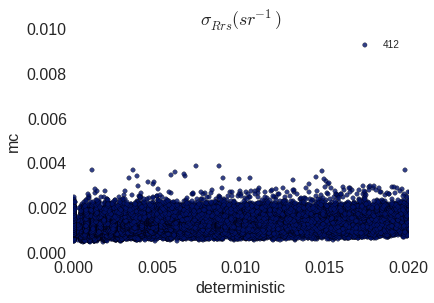

In [22]:
SigmaScatter(Sig412,Rrs_412unc,xlims=(0,0.02),ylims=(0,0.01),band='412',color=color412)

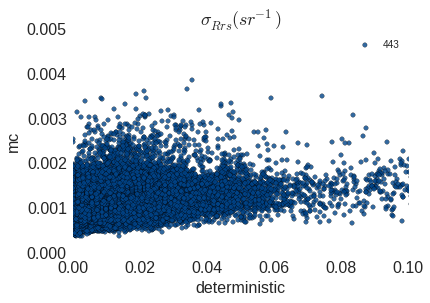

In [32]:
SigmaScatter(Sig443,Rrs_443unc,xlims=(0,0.1),ylims=(0,0.005),band='443',color=color443)

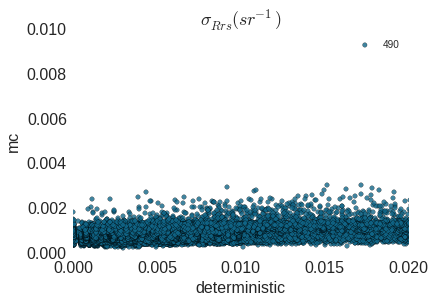

In [24]:
SigmaScatter(Sig490,Rrs_490unc,xlims=(0,0.02),ylims=(0,0.01),band='490',color=color490)

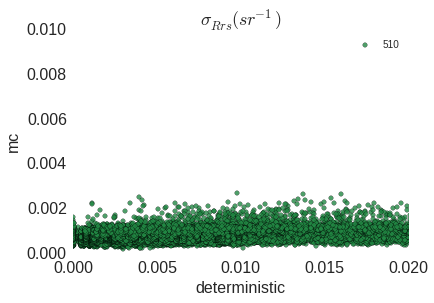

In [25]:
SigmaScatter(Sig510,Rrs_510unc,xlims=(0,0.02),ylims=(0,0.01),band='510',color=color510)

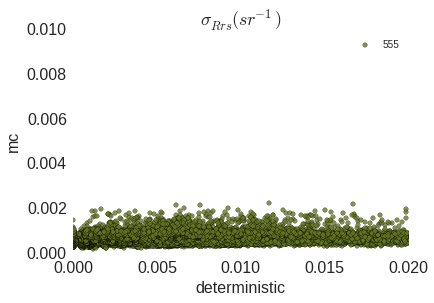

In [26]:
SigmaScatter(Sig555,Rrs_555unc,xlims=(0,0.02),ylims=(0,0.01),band='555',color=color555)

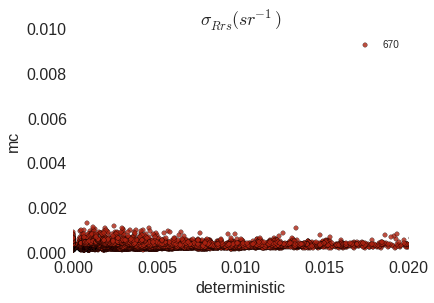

In [27]:
SigmaScatter(Sig670,Rrs_670unc,xlims=(0,0.02),ylims=(0,0.01),band='670',color=color670)

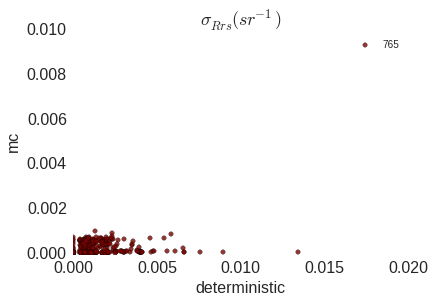

In [28]:
SigmaScatter(Sig765,Rrs_765unc,xlims=(0,0.02),ylims=(0,0.02),band='765',color=color765)

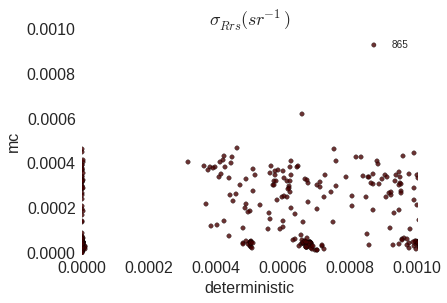

In [29]:
SigmaScatter(Sig865,Rrs_865unc,xlims=(0,0.001),ylims=(0,0.001),band='865',color=color865)

In [38]:
print "product from "+fnpath+ "not found"

product from ./DATA/L2/S2003182003236_silent_Det.L2not found


In [42]:
a=geoVarBsl.keys()
b=geoVarBsl[a[0]]

(3930, 248)

In [36]:
dsBsl.close()
fnbndir='./DATA/L2/'
fnbn='S2003182003236'
fnsilsfx='_silent_Det.L2'
fnpath = fnbndir+fnbn+fnsilsfx
dsBsl,geoVarBsl = GetNCRefs(fnpath,mode='r+')
detRrs_412unc = GetOrCreateUnc('Rrs_unc_412',geoVarBsl,ds=dsBsl)
detRrs_443unc = GetOrCreateUnc('Rrs_unc_443',geoVarBsl,ds=dsBsl)
detRrs_490unc = GetOrCreateUnc('Rrs_unc_490',geoVarBsl,ds=dsBsl)
detRrs_510unc = GetOrCreateUnc('Rrs_unc_510',geoVarBsl,ds=dsBsl)
detRrs_555unc = GetOrCreateUnc('Rrs_unc_555',geoVarBsl,ds=dsBsl)
detRrs_670unc = GetOrCreateUnc('Rrs_unc_670',geoVarBsl,ds=dsBsl)
detRrs_765unc = GetOrCreateUnc('Rrs_unc_765',geoVarBsl,ds=dsBsl)
detRrs_865unc = GetOrCreateUnc('Rrs_unc_865',geoVarBsl,ds=dsBsl)

In [ ]:
def WriteUncToFile(path,uncDict,ncVarNamesDict):
    
    # get access to file
    ds = nc.Dataset(path)
    gr = ds.groups['geophysical_data']
    grv = gr.variables
    keys = grv.keys()
    dimNames = grv[keys[0]].dimensions
    shape = grv[keys[0]].shape
    datType = uncDict.keys()[0]
    
    for band in ncVarNamesDict.keys()
        # go through the uncertainty dictionary
        # reshape data so it matches the data in the nc file
        
        prodName = ncVarNamesDict[name]
        tempArray = np.reshape(uncDict[name],shape)
        
        if prodName not in grv:
            
            # create new variable if not available
            ncData = gr.createVariable(name,datType,dimNames)
            ncData[:] = tempArray
            
        else:
            
            grv[prodName][:] = tempArray